Importanje knjiznjic

In [33]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt 

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.optimizers import Adam

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow Version: 2.16.2
NumPy Version: 1.26.4
Pandas Version: 2.2.3
OpenCV Version: 4.11.0
Num GPUs Available: 1


In [34]:
# --- PARAMETRI ---
IMG_SIZE = (224, 224) # Velikost slik za model
NUM_CLASSES = 1       # 1 izhodni nevron za binarno klasifikacijo (sigmoid)
BATCH_SIZE = 32       # Velikost serije za treniranje
NUM_EPOCHS = 50       # Število epoh (začni z majhnim, EarlyStopping bo pomagal)

In [35]:
# --- FUNKCIJA ZA NALAGANJE IN PREDPROCESIRANJE SLIK ---
def load_and_preprocess_image(image_path, label):
    # Pretvorimo pot v string (tf.string) in nato naložimo sliko
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Predpostavljamo JPEG, 3 kanali (RGB), dekodira v uint8 [0, 255]
    img = tf.image.resize(img, IMG_SIZE) # Spremeni velikost na ciljno velikost
    # NE pretvarjamo v float32 in [0,1] tukaj, pustimo [0, 255] za EfficientNetV2B0 in kasnejšo obdelavo za MobileNetV2
    return img, label

In [36]:
# --- NALAGANJE PODATKOV IZ CSV-jev ---
# Poti do CSV datotek
train_csv_path = '../data/splits/train_data.csv'
val_csv_path = '../data/splits/val_data.csv'
test_csv_path = '../data/splits/test_data.csv'

# Preverimo, ali datoteke obstajajo
import os
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(f"Datoteka '{train_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")
if not os.path.exists(val_csv_path):
    raise FileNotFoundError(f"Datoteka '{val_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"Datoteka '{test_csv_path}' ne obstaja. Preverite pot ali izvedite 04_prepare_dataset_for_training.ipynb.")

In [37]:
# Naloži DataFrames
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

print(f"\nNaloženi podatki:")
print(f"Učna množica: {len(train_df)} slik")
print(f"Validacijska množica: {len(val_df)} slik")
print(f"Testna množica: {len(test_df)} slik")


Naloženi podatki:
Učna množica: 784 slik
Validacijska množica: 169 slik
Testna množica: 169 slik


### --- PRIPRAVA TF.DATA.DATASET OBJEKTOV ---

In [38]:
# Dataset za treniranje
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000) # Premešaj podatke
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) # Optimizacija nalaganja

In [39]:
# Dataset za validacijo
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [40]:
# Dataset za testiranje
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image_path'].values, test_df['label'].values))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### --- GRADNJA IN TREINIRANJE MODELA 1: MobileNetV2 ---

In [41]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: MobileNetV2 ---")
try:
    # 1. Naložitev osnovnega modela (MobileNetV2)
    # include_top=False: odstranimo klasifikacijsko glavo
    # weights='imagenet': naložimo uteži naučene na ImageNetu
    base_model_mobilenet = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_mobilenet.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_mobilenet = tf.keras.Input(shape=IMG_SIZE + (3,))

    # DODATNO PREDPROCESIRANJE ZA MOBILENETV2 (skaliranje v [-1, 1])
    x_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input(inputs_mobilenet)

    x_mobilenet = base_model_mobilenet(x_mobilenet)
    x_mobilenet = tf.keras.layers.GlobalAveragePooling2D()(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dense(128, activation='gelu')(x_mobilenet)
    x_mobilenet = tf.keras.layers.Dropout(0.2)(x_mobilenet)
    outputs_mobilenet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_mobilenet)

    model_mobilenet = tf.keras.Model(inputs=inputs_mobilenet, outputs=outputs_mobilenet, name="MobileNetV2_Classifier")

    # 3. Kompilacija modela
    model_mobilenet.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

    model_mobilenet.summary()

    # 4. Callbacki za treniranje
    callbacks_mobilenet = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        # ModelCheckpoint(filepath='best_mobilenet_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje MobileNetV2...")
    history_mobilenet = model_mobilenet.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_mobilenet
    )
    print("\nTreniranje MobileNetV2 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri MobileNetV2: {e}")
    history_mobilenet = None # Zagotovimo, da history obstaja, tudi če pride do napake


--- GRADNJA IN TREINIRANJE MODELA: MobileNetV2 ---


Model: "MobileNetV2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Začenjam treniranje MobileNetV2...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8468 - loss: 0.2483 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - loss: 8.1506e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 7.1174e-04 - val_accuracy: 1.0000 - val_loss: 8.5309e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - loss: 3.1463e-04 - val_accuracy: 1.0000 - val_loss: 8.2883e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 3.9393e-04 - val_accuracy: 1.0000 - val_loss: 6.8611e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 3.2513e-04 - val_accuracy: 1.0000 - val_loss: 6.0910e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 

### --- GRADNJA IN TREINIRANJE MODELA 2: EfficientNetV2B0 ---

In [42]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---")

try:
    # 1. Naložitev osnovnega modela (EfficientNetV2B0)
    # include_preprocessing=True (privzeto) pomeni, da model sam obdela [0, 255] vhode
    # Namesto EfficientNetV2B0 poskusi:
    base_model_efficientnet = tf.keras.applications.EfficientNetV2B1( # ali B2, B3
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_efficientnet.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_efficientnet = tf.keras.Input(shape=IMG_SIZE + (3,))
    # Ni potrebe po dodatnem preprocessingu tukaj, ker EfficientNetV2B0 to že vključi
    x_efficientnet = base_model_efficientnet(inputs_efficientnet)
    x_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dense(128, activation='relu')(x_efficientnet)
    x_efficientnet = tf.keras.layers.Dropout(0.2)(x_efficientnet)
    outputs_efficientnet = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_efficientnet)

    model_efficientnet = tf.keras.Model(inputs=inputs_efficientnet, outputs=outputs_efficientnet, name="EfficientNetV2B0_Classifier")

    # 3. Kompilacija modela
    model_efficientnet.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

    model_efficientnet.summary()

    # 4. Callbacki za treniranje
    callbacks_efficientnet = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        # ModelCheckpoint(filepath='best_efficientnet_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje EfficientNetV2B0...")
    history_efficientnet = model_efficientnet.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_efficientnet
    )
    print("\nTreniranje EfficientNetV2B0 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri EfficientNetV2B0: {e}")
    history_efficientnet = None # Zagotovimo, da history obstaja, tudi če pride do napake



--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B0 ---


Model: "EfficientNetV2B0_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,095,221 (27.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 6,931,124 (26.44 MB)


Začenjam treniranje EfficientNetV2B0...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 392ms/step - accuracy: 0.8889 - loss: 0.2293 - val_accuracy: 1.0000 - val_loss: 9.9380e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 4.0390e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 2.0864e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 5.7680e-04 - val_accuracy: 1.0000 - val_loss: 2.3044e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 1.6664e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 7.4461e-04 - val_accuracy: 1.0000 - val_loss: 1.4404e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 3.1577e-04 - val_accuracy: 1.0000 - val_loss: 1.2121e-04
Epoch 8/50
25/25 ━━━━━━━━━━

## --- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---

In [43]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---")
try:
    # 1. Naložitev osnovnega modela (EfficientNetV2B3)
    # include_top=False: odstranimo klasifikacijsko glavo
    # weights='imagenet': naložimo uteži naučene na ImageNetu
    # EfficientNetV2B3 ima vgrajen preprocessing za vhode v območju [0, 255]
    base_model_efficientnet_b3 = tf.keras.applications.EfficientNetV2B3(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_efficientnet_b3.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_efficientnet_b3 = tf.keras.Input(shape=IMG_SIZE + (3,))
    # Ni potrebe po dodatnem preprocessingu tukaj, ker EfficientNetV2B3 to že vključi
    x_efficientnet_b3 = base_model_efficientnet_b3(inputs_efficientnet_b3)
    x_efficientnet_b3 = tf.keras.layers.GlobalAveragePooling2D()(x_efficientnet_b3)
    x_efficientnet_b3 = tf.keras.layers.Dense(256, activation='gelu')(x_efficientnet_b3) # Povečano število nevronov
    x_efficientnet_b3 = tf.keras.layers.Dropout(0.3)(x_efficientnet_b3) # Povečan dropout
    outputs_efficientnet_b3 = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_efficientnet_b3)

    model_efficientnet_b3 = tf.keras.Model(inputs=inputs_efficientnet_b3, outputs=outputs_efficientnet_b3, name="EfficientNetV2B3_Classifier")

    # 3. Kompilacija modela
    # Uporaba eksplicitnega optimizatorja za lažje prilagajanje learning rate
    optimizer_efficientnet_b3 = Adam(learning_rate=0.0001) # Prilagojena učna hitrost
    model_efficientnet_b3.compile(optimizer=optimizer_efficientnet_b3,
                                  loss='binary_crossentropy',
                                  metrics=['accuracy'])

    model_efficientnet_b3.summary()

    # 4. Callbacki za treniranje
    callbacks_efficientnet_b3 = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True), # Povečan patience
        ModelCheckpoint(filepath='best_efficientnetv2b3_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje EfficientNetV2B3...")
    history_efficientnet_b3 = model_efficientnet_b3.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_efficientnet_b3
    )
    print("\nTreniranje EfficientNetV2B3 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri EfficientNetV2B3: {e}")
    history_efficientnet_b3 = None


--- GRADNJA IN TREINIRANJE MODELA: EfficientNetV2B3 ---


Model: "EfficientNetV2B3_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,324,351 (50.83 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 12,930,622 (49.33 MB)


Začenjam treniranje EfficientNetV2B3...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 504ms/step - accuracy: 0.8401 - loss: 0.4497 - val_accuracy: 1.0000 - val_loss: 0.1202
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9887 - loss: 0.1006 - val_accuracy: 1.0000 - val_loss: 0.0436
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9981 - loss: 0.0427 - val_accuracy: 1.0000 - val_loss: 0.0235
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9996 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9990 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9949 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9976 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy

## --- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---

In [44]:
print("\n--- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---")
try:
    # 1. Naložitev osnovnega modela (ResNet50V2)
    base_model_resnet50v2 = tf.keras.applications.ResNet50V2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model_resnet50v2.trainable = False # Zamrznemo uteži osnovnega modela

    # 2. Sestavljanje celotnega modela z Functional API
    inputs_resnet50v2 = tf.keras.Input(shape=IMG_SIZE + (3,))

    # POMEMBNO: DODATNO PREDPROCESIRANJE ZA RESNET50V2 (skaliranje v [-1, 1] ali specifično)
    # ResNetV2 modeli pričakujejo vhodne vrednosti, ki so že predprocesirane.
    # To se naredi z uporabo tf.keras.applications.resnet_v2.preprocess_input
    x_resnet50v2 = tf.keras.applications.resnet_v2.preprocess_input(inputs_resnet50v2)

    x_resnet50v2 = base_model_resnet50v2(x_resnet50v2)
    x_resnet50v2 = tf.keras.layers.GlobalAveragePooling2D()(x_resnet50v2)
    x_resnet50v2 = tf.keras.layers.Dense(256, activation='gelu')(x_resnet50v2) # Povečano število nevronov
    x_resnet50v2 = tf.keras.layers.Dropout(0.3)(x_resnet50v2) # Povečan dropout
    outputs_resnet50v2 = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x_resnet50v2)

    model_resnet50v2 = tf.keras.Model(inputs=inputs_resnet50v2, outputs=outputs_resnet50v2, name="ResNet50V2_Classifier")

    # 3. Kompilacija modela
    optimizer_resnet50v2 = Adam(learning_rate=0.0001) # Prilagojena učna hitrost
    model_resnet50v2.compile(optimizer=optimizer_resnet50v2,
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    model_resnet50v2.summary()

    # 4. Callbacki za treniranje
    callbacks_resnet50v2 = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True), # Povečan patience
        ModelCheckpoint(filepath='best_resnet50v2_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # 5. Treniranje modela
    print("\nZačenjam treniranje ResNet50V2...")
    history_resnet50v2 = model_resnet50v2.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_resnet50v2
    )
    print("\nTreniranje ResNet50V2 zaključeno.")

except Exception as e:
    print(f"\nPrišlo je do napake pri ResNet50V2: {e}")
    history_resnet50v2 = None


--- GRADNJA IN TREINIRANJE MODELA: ResNet50V2 ---


Model: "ResNet50V2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Začenjam treniranje ResNet50V2...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.7932 - loss: 0.4288 - val_accuracy: 1.0000 - val_loss: 0.0517
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9972 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9998 - loss: 0.0220 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9989 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 1.00

### --- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

In [45]:
print("\n--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---")

# MobileNetV2
if history_mobilenet is not None:
    print("\nOcenjevanje MobileNetV2 na testni množici:")
    loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_dataset)
    print(f"MobileNetV2 - Testna izguba: {loss_mobilenet:.4f}, Testna natančnost: {acc_mobilenet:.4f}")
else:
    print("\nMobileNetV2 ni bil treniran zaradi napake.")
    loss_mobilenet, acc_mobilenet = None, None

# EfficientNetV2B0
if history_efficientnet is not None:
    print("\nOcenjevanje EfficientNetV2B0 na testni množici:")
    loss_efficientnet, acc_efficientnet = model_efficientnet.evaluate(test_dataset)
    print(f"EfficientNetV2B0 - Testna izguba: {loss_efficientnet:.4f}, Testna natančnost: {acc_efficientnet:.4f}")
else:
    print("\nEfficientNetV2B0 ni bil treniran zaradi napake.")
    loss_efficientnet, acc_efficientnet = None, None

# EfficientNetV2B3 (NOV)
if history_efficientnet_b3 is not None:
    print("\nOcenjevanje EfficientNetV2B3 na testni množici:")
    loss_efficientnet_b3, acc_efficientnet_b3 = model_efficientnet_b3.evaluate(test_dataset)
    print(f"EfficientNetV2B3 - Testna izguba: {loss_efficientnet_b3:.4f}, Testna natančnost: {acc_efficientnet_b3:.4f}")
else:
    print("\nEfficientNetV2B3 ni bil treniran zaradi napake.")
    loss_efficientnet_b3, acc_efficientnet_b3 = None, None

# ResNet50V2 (NOV)
if history_resnet50v2 is not None:
    print("\nOcenjevanje ResNet50V2 na testni množici:")
    loss_resnet50v2, acc_resnet50v2 = model_resnet50v2.evaluate(test_dataset)
    print(f"ResNet50V2 - Testna izguba: {loss_resnet50v2:.4f}, Testna natančnost: {acc_resnet50v2:.4f}")
else:
    print("\nResNet50V2 ni bil treniran zaradi napake.")
    loss_resnet50v2, acc_resnet50v2 = None, None



--- OCENJEVANJE MODELOV NA TESTNI MNOŽICI ---

Ocenjevanje MobileNetV2 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 3.2519e-05
MobileNetV2 - Testna izguba: 0.0000, Testna natančnost: 1.0000

Ocenjevanje EfficientNetV2B0 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 4.3786e-05
EfficientNetV2B0 - Testna izguba: 0.0001, Testna natančnost: 1.0000

Ocenjevanje EfficientNetV2B3 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.6268e-04
EfficientNetV2B3 - Testna izguba: 0.0006, Testna natančnost: 1.0000

Ocenjevanje ResNet50V2 na testni množici:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.6886e-04
ResNet50V2 - Testna izguba: 0.0003, Testna natančnost: 1.0000


### --- VIZUALIZACIJA REZULTATOV ---


--- VIZUALIZACIJA REZULTATOV ---


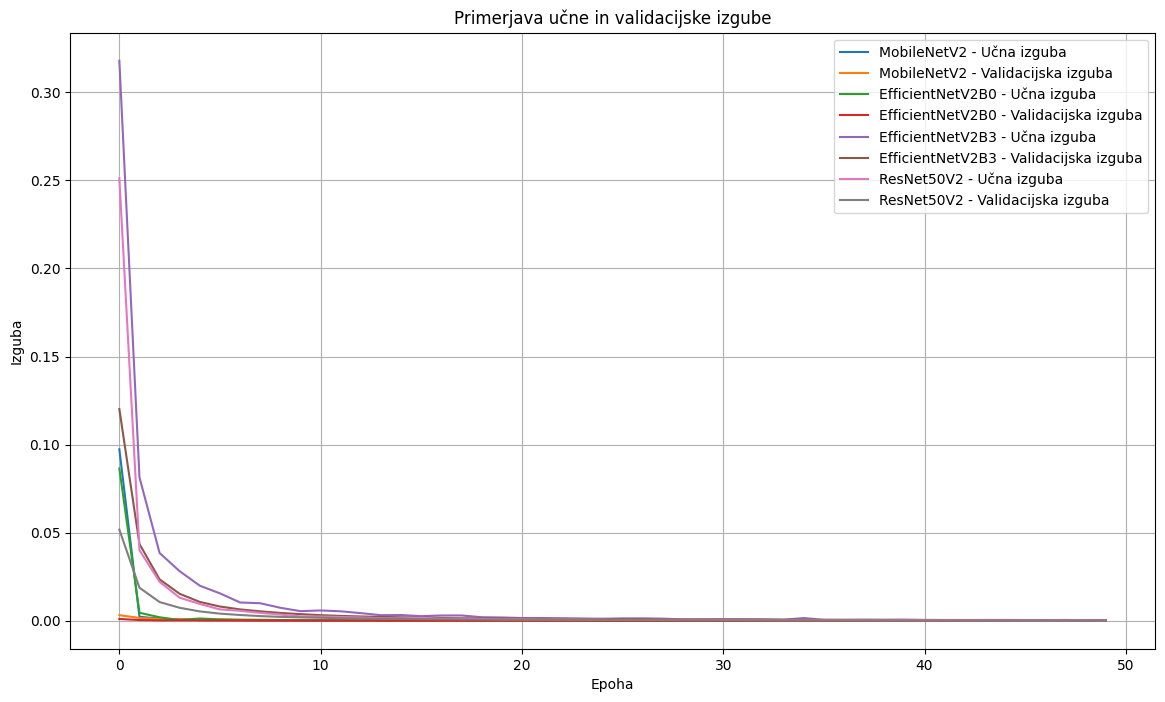

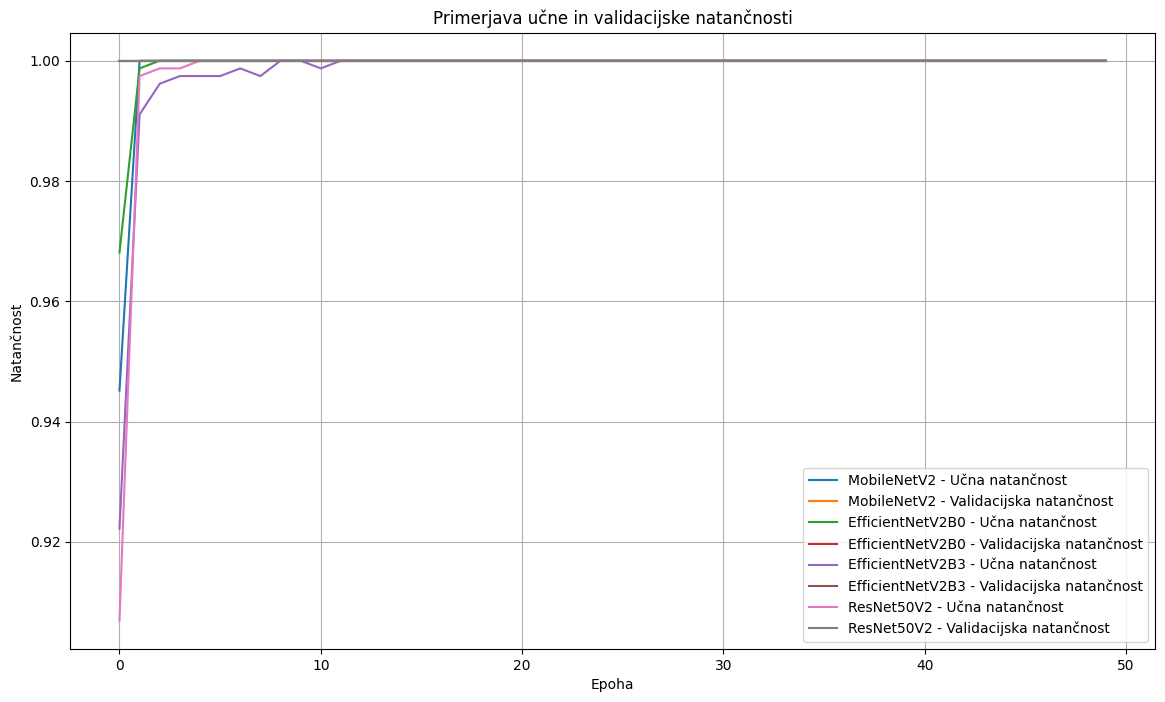


--- Povzetek končnih rezultatov na testni množici ---
           Model Testna izguba Testna natančnost
     MobileNetV2        0.0000            1.0000
EfficientNetV2B0        0.0001            1.0000
EfficientNetV2B3        0.0006            1.0000
      ResNet50V2        0.0003            1.0000


In [46]:
print("\n--- VIZUALIZACIJA REZULTATOV ---")

# Preverimo, ali so vsi potrebni objekti 'history' na voljo za risanje grafov
if (history_mobilenet is not None and history_efficientnet is not None and
    history_efficientnet_b3 is not None and history_resnet50v2 is not None):

    # Graf izgube (Loss)
    plt.figure(figsize=(14, 8)) # Povečana velikost grafa
    plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 - Učna izguba')
    plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 - Validacijska izguba')
    plt.plot(history_efficientnet.history['loss'], label='EfficientNetV2B0 - Učna izguba')
    plt.plot(history_efficientnet.history['val_loss'], label='EfficientNetV2B0 - Validacijska izguba')
    plt.plot(history_efficientnet_b3.history['loss'], label='EfficientNetV2B3 - Učna izguba') # NOV
    plt.plot(history_efficientnet_b3.history['val_loss'], label='EfficientNetV2B3 - Validacijska izguba') # NOV
    plt.plot(history_resnet50v2.history['loss'], label='ResNet50V2 - Učna izguba') # NOV
    plt.plot(history_resnet50v2.history['val_loss'], label='ResNet50V2 - Validacijska izguba') # NOV
    plt.title('Primerjava učne in validacijske izgube')
    plt.xlabel('Epoha')
    plt.ylabel('Izguba')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graf natančnosti (Accuracy)
    plt.figure(figsize=(14, 8)) # Povečana velikost grafa
    plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 - Učna natančnost')
    plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 - Validacijska natančnost')
    plt.plot(history_efficientnet.history['accuracy'], label='EfficientNetV2B0 - Učna natančnost')
    plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetV2B0 - Validacijska natančnost')
    plt.plot(history_efficientnet_b3.history['accuracy'], label='EfficientNetV2B3 - Učna natančnost') # NOV
    plt.plot(history_efficientnet_b3.history['val_accuracy'], label='EfficientNetV2B3 - Validacijska natančnost') # NOV
    plt.plot(history_resnet50v2.history['accuracy'], label='ResNet50V2 - Učna natančnost') # NOV
    plt.plot(history_resnet50v2.history['val_accuracy'], label='ResNet50V2 - Validacijska natančnost') # NOV
    plt.title('Primerjava učne in validacijske natančnosti')
    plt.xlabel('Epoha')
    plt.ylabel('Natančnost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tabela končnih rezultatov
    print("\n--- Povzetek končnih rezultatov na testni množici ---")
    results = pd.DataFrame({
        'Model': ['MobileNetV2', 'EfficientNetV2B0', 'EfficientNetV2B3', 'ResNet50V2'], # Posodobljeni modeli
        'Testna izguba': [f'{loss_mobilenet:.4f}' if loss_mobilenet is not None else 'N/A',
                         f'{loss_efficientnet:.4f}' if loss_efficientnet is not None else 'N/A',
                         f'{loss_efficientnet_b3:.4f}' if loss_efficientnet_b3 is not None else 'N/A', # NOV
                         f'{loss_resnet50v2:.4f}' if loss_resnet50v2 is not None else 'N/A'], # NOV
        'Testna natančnost': [f'{acc_mobilenet:.4f}' if acc_mobilenet is not None else 'N/A',
                              f'{acc_efficientnet:.4f}' if acc_efficientnet is not None else 'N/A',
                              f'{acc_efficientnet_b3:.4f}' if acc_efficientnet_b3 is not None else 'N/A', # NOV
                              f'{acc_resnet50v2:.4f}' if acc_resnet50v2 is not None else 'N/A'] # NOV
    })
    print(results.to_string(index=False))

else:
    print("\nVizualizacija in povzetek nista mogoča, ker vsaj en model ni bil uspešno treniran.")



In [47]:
# %%
# Nadaljevanje tvoje kode po treniranju obeh modelov

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt # Za prikaz slik
import os # Za os.path.basename

# --- FUNKCIJA ZA ZAZNAVANJE IN PREDPROCESIRANJE OBRAZA ZA SKLEPANJE ---
# Funkcija zdaj vrne tudi sliko, ki je pripravljena za prikaz (obrezana, resized, v [0, 255])
def preprocess_for_prediction(image_path, target_size=(224, 224), model_type='mobilenet'):
    """
    Naloži sliko, zazna in obreže obraz ter ga predprocesira za model.
    Vrne tudi sliko, ki je pripravljena za prikaz (BGR format, [0, 255]).

    Args:
        image_path (str): Pot do slike.
        target_size (tuple): Ciljna velikost slike za model (širina, višina).
        model_type (str): 'mobilenet', 'efficientnet' ali 'resnet' za pravilno normalizacijo.

    Returns:
        tuple: (np.array procesirana_slika_za_model, np.array slika_za_prikaz)
               ali (None, None) če obraz ni zaznan.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Napaka: Slike ni mogoče naložiti iz {image_path}")
        return None, None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("Ni zaznanih obrazov na sliki.")
        return None, None
    elif len(faces) > 1:
        print("Zaznanih je več obrazov. Uporabljam največjega.")
        (x, y, w, h) = max(faces, key=lambda f: f[2] * f[3])
    else:
        (x, y, w, h) = faces[0]

    # Obreži obraz (dodamo malo roba)
    margin_x = int(w * 0.1)
    margin_y = int(h * 0.1)
    x1 = max(0, x - margin_x)
    y1 = max(0, y - margin_y)
    x2 = min(img.shape[1], x + w + margin_x)
    y2 = min(img.shape[0], y + h + margin_y)

    face_crop = img[y1:y2, x1:x2]
    face_resized = cv2.resize(face_crop, target_size)

    # Slika, ki jo bomo prikazali (BGR format, [0, 255])
    display_img = face_resized.copy()

    # Normalizacija in pretvorba v ustrezen tip za model
    if model_type == 'mobilenet':
        face_processed = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(face_resized, axis=0))
    elif model_type == 'efficientnet': # Velja za B0, B3 in ostale EfficientNetV2
        face_processed = np.expand_dims(face_resized, axis=0).astype(np.float32) # Ostane v [0, 255]
    elif model_type == 'resnet': # NOV
        face_processed = tf.keras.applications.resnet_v2.preprocess_input(np.expand_dims(face_resized, axis=0))
    else:
        raise ValueError("Neznan tip modela. Uporabi 'mobilenet', 'efficientnet' ali 'resnet'.")

    return face_processed, display_img


--- Testiranje na sliki: ../data/raw/slike/face_214_aug_2_cleaned_frame_0310.jpg (Moj obraz) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


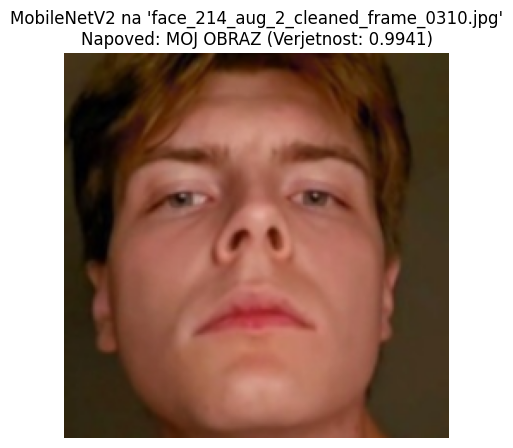

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


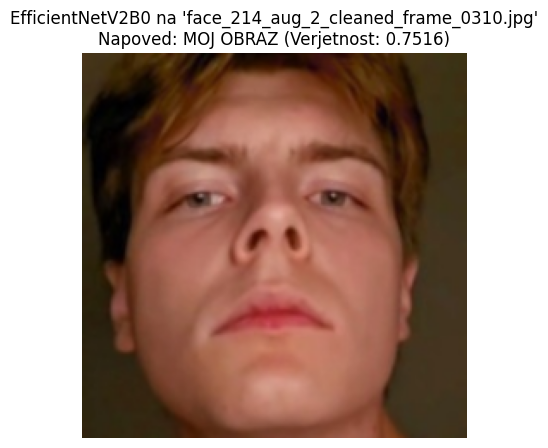

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


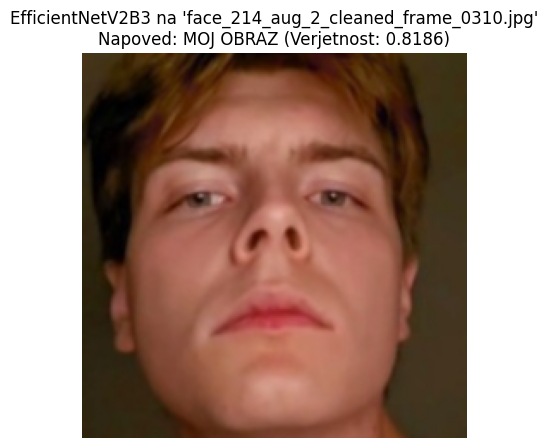

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


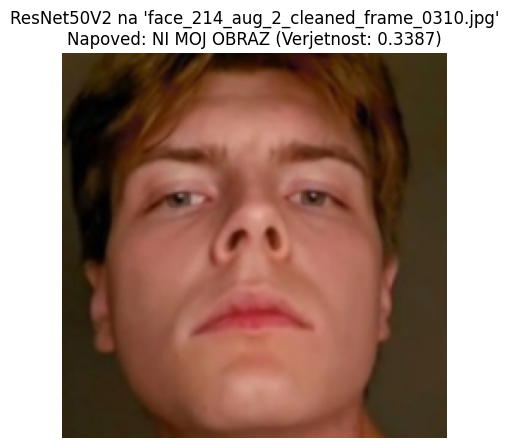


--- Testiranje na sliki: ../data/raw/slike/LaraDoma.jpeg (Drugi obraz) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


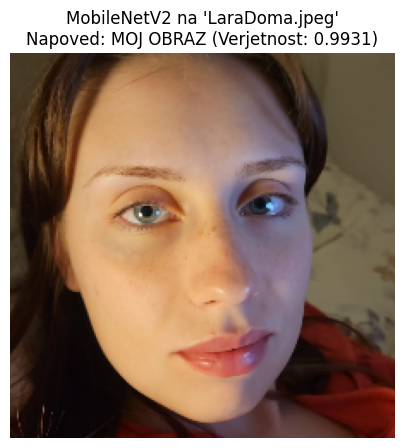

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


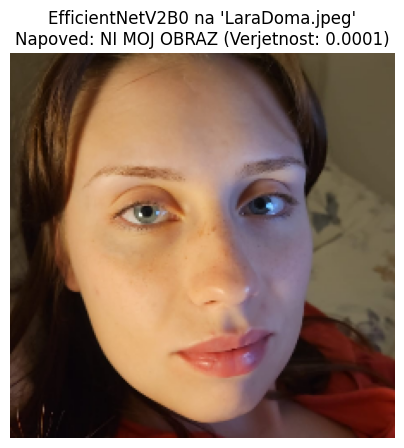

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


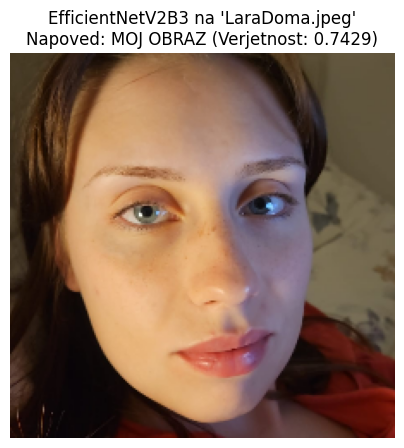

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


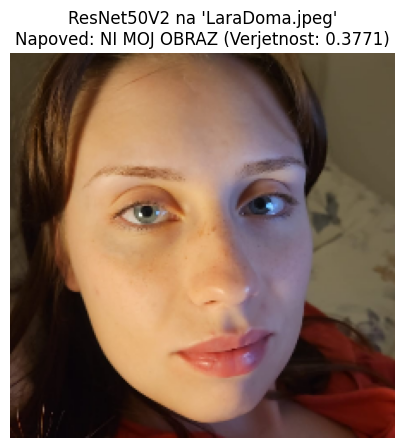

In [48]:
# --- PRIMER UPORABE NA POSAMEZNI SLIKI ---

# Naloži testno sliko (pot do neke slike, ki jo želiš preizkusiti)
# Uporabi pot do slike, ki je ni bilo v učnih podatkih!
test_image_path_me = '../data/raw/slike/face_214_aug_2_cleaned_frame_0310.jpg' # PRIMER: Pot do slike tebe
test_image_path_other = '../data/raw/slike/LaraDoma.jpeg' # Zamenjaj s pravilno potjo

# --- POMOŽNA FUNKCIJA ZA PRIKAZ REZULTATOV ---
def display_prediction(model_name, prediction_prob, display_img, original_filename):
    """Prikaže obdelano sliko in napoved modela."""
    predicted_label = "MOJ OBRAZ" if prediction_prob > 0.5 else "NI MOJ OBRAZ"
    
    plt.figure(figsize=(5, 5))
    # OpenCV bere kot BGR, Matplotlib pričakuje RGB
    plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{model_name} na '{original_filename}'\n"
              f"Napoved: {predicted_label} (Verjetnost: {prediction_prob:.4f})")
    plt.axis('off')
    plt.show()


# %%
# --- Testiranje na sliki: Moj obraz ---
print(f"\n--- Testiranje na sliki: {test_image_path_me} (Moj obraz) ---")

if model_mobilenet is not None:
    processed_img_mobilenet_me, display_img_mobilenet_me = preprocess_for_prediction(test_image_path_me, IMG_SIZE, model_type='mobilenet')
    if processed_img_mobilenet_me is not None:
        prediction_mobilenet_me = model_mobilenet.predict(processed_img_mobilenet_me)[0][0]
        display_prediction("MobileNetV2", prediction_mobilenet_me, display_img_mobilenet_me, os.path.basename(test_image_path_me))

if model_efficientnet is not None: # Za B0
    processed_img_efficientnet_b0_me, display_img_efficientnet_b0_me = preprocess_for_prediction(test_image_path_me, IMG_SIZE, model_type='efficientnet')
    if processed_img_efficientnet_b0_me is not None:
        prediction_efficientnet_b0_me = model_efficientnet.predict(processed_img_efficientnet_b0_me)[0][0]
        display_prediction("EfficientNetV2B0", prediction_efficientnet_b0_me, display_img_efficientnet_b0_me, os.path.basename(test_image_path_me))

if model_efficientnet_b3 is not None: # NOV
    processed_img_efficientnet_b3_me, display_img_efficientnet_b3_me = preprocess_for_prediction(test_image_path_me, IMG_SIZE, model_type='efficientnet')
    if processed_img_efficientnet_b3_me is not None:
        prediction_efficientnet_b3_me = model_efficientnet_b3.predict(processed_img_efficientnet_b3_me)[0][0]
        display_prediction("EfficientNetV2B3", prediction_efficientnet_b3_me, display_img_efficientnet_b3_me, os.path.basename(test_image_path_me))

if model_resnet50v2 is not None: # NOV
    processed_img_resnet50v2_me, display_img_resnet50v2_me = preprocess_for_prediction(test_image_path_me, IMG_SIZE, model_type='resnet')
    if processed_img_resnet50v2_me is not None:
        prediction_resnet50v2_me = model_resnet50v2.predict(processed_img_resnet50v2_me)[0][0]
        display_prediction("ResNet50V2", prediction_resnet50v2_me, display_img_resnet50v2_me, os.path.basename(test_image_path_me))


# %%
# --- Testiranje na sliki: Drugi obraz ---
print(f"\n--- Testiranje na sliki: {test_image_path_other} (Drugi obraz) ---")

if model_mobilenet is not None:
    processed_img_mobilenet_other, display_img_mobilenet_other = preprocess_for_prediction(test_image_path_other, IMG_SIZE, model_type='mobilenet')
    if processed_img_mobilenet_other is not None:
        prediction_mobilenet_other = model_mobilenet.predict(processed_img_mobilenet_other)[0][0]
        display_prediction("MobileNetV2", prediction_mobilenet_other, display_img_mobilenet_other, os.path.basename(test_image_path_other))

if model_efficientnet is not None: # Za B0
    processed_img_efficientnet_b0_other, display_img_efficientnet_b0_other = preprocess_for_prediction(test_image_path_other, IMG_SIZE, model_type='efficientnet')
    if processed_img_efficientnet_b0_other is not None:
        prediction_efficientnet_b0_other = model_efficientnet.predict(processed_img_efficientnet_b0_other)[0][0]
        display_prediction("EfficientNetV2B0", prediction_efficientnet_b0_other, display_img_efficientnet_b0_other, os.path.basename(test_image_path_other))

if model_efficientnet_b3 is not None: # NOV
    processed_img_efficientnet_b3_other, display_img_efficientnet_b3_other = preprocess_for_prediction(test_image_path_other, IMG_SIZE, model_type='efficientnet')
    if processed_img_efficientnet_b3_other is not None:
        prediction_efficientnet_b3_other = model_efficientnet_b3.predict(processed_img_efficientnet_b3_other)[0][0]
        display_prediction("EfficientNetV2B3", prediction_efficientnet_b3_other, display_img_efficientnet_b3_other, os.path.basename(test_image_path_other))

if model_resnet50v2 is not None: # NOV
    processed_img_resnet50v2_other, display_img_resnet50v2_other = preprocess_for_prediction(test_image_path_other, IMG_SIZE, model_type='resnet')
    if processed_img_resnet50v2_other is not None:
        prediction_resnet50v2_other = model_resnet50v2.predict(processed_img_resnet50v2_other)[0][0]
        display_prediction("ResNet50V2", prediction_resnet50v2_other, display_img_resnet50v2_other, os.path.basename(test_image_path_other))